---
title: "Corona"
bibliography: TC_m1_s4_references.bib
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## Preparation and overview

### Imports and options

In [1]:
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
from module1_s4_functions import *
import numpy.typing as npt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import gmean
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go
import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from datetime import datetime
import json
import requests
import time
import pickle
pio.renderers.default = "plotly_mimetype+notebook_connected"

In [2]:
color_scheme={}

### Loading and cleaning

In [3]:
pd.set_option("display.float_format", "{:.3g}".format)
base_fig_wid = 9  # base width of a figure
base_font_size = 12  # base size of a font
dpi = 96
plt.rcParams["font.size"] = base_font_size

Putting the data from separate in .csv files into a dictionary of pandas dataframes

In [4]:
data_files = csv_files = [f for f in os.listdir("data") if f.endswith(".csv")]
data = {}
for file in csv_files:
    file_path = os.path.join("data/", file)
    df = pd.read_csv(file_path)
    data[file[:-4]] = df

1. The Lists of Data Table
1) Case Data
Case: Data of COVID-19 infection cases in South Korea
2) Patient Data
PatientInfo: Epidemiological data of COVID-19 patients in South Korea
PatientRoute: Route data of COVID-19 patients in South Korea (currently unavailable)
3) Time Series Data
Time: Time series data of COVID-19 status in South Korea
TimeAge: Time series data of COVID-19 status in terms of the age in South Korea
TimeGender: Time series data of COVID-19 status in terms of gender in South Korea
TimeProvince: Time series data of COVID-19 status in terms of the Province in South Korea
4) Additional Data
Region: Location and statistical data of the regions in South Korea
Weather: Data of the weather in the regions of South Korea
SearchTrend: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea
SeoulFloating: Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
Policy: Data of the government policy for COVID-19 in South Korea

Formatting the date data:

In [5]:
date_format = '%Y-%m-%d'
data['Time']['date'] = pd.to_datetime(data['Time']['date'])
data['Time'].set_index('date',inplace=True)
data['Weather']['date']=pd.to_datetime(data['Weather']['date'])


Adding a new cases column:

In [6]:
data['Time']['new_cases'] = data['Time']['confirmed'] - data['Time']['confirmed'].shift(1)

### Preparation of weekly data

Weekly data:

In [7]:
weekly_time=data['Time'].resample('W').last()

New cases per week:

In [8]:
weekly_time["new_cases"] = weekly_time["confirmed"] - weekly_time["confirmed"].shift(
    1
).fillna(0)

Weekly tests done:

In [9]:
weekly_time["weekly_tested"] = weekly_time["test"] - weekly_time["test"].shift(
    1
).fillna(0)

Percentage of positive tests:

In [10]:
weekly_time['positivity'] = weekly_time['new_cases']/weekly_time['weekly_tested']*100

## Timeline overview of total infections

### Rate of the spread as a function of total cases

Creating a two day doubling line:

In [11]:
# Create an array of dates starting from the start date
dates = pd.date_range(start='2020-01-20', end='2020-06-30', freq='2D')

# Create an array of confirmed cases that doubles every two days
confirmed_cases = np.power(2, np.arange(len(dates) // 2 + 1))
confirmed_cases = np.tile(confirmed_cases, 2)[:len(dates)]

# Create an array of new cases for each date
new_cases = np.zeros(len(dates))
new_cases[0] = confirmed_cases[0]
# Create a DataFrame with the date, confirmed, and new cases columns
doubling_line = pd.DataFrame({'date': dates, 'confirmed': confirmed_cases})
doubling_line['new_cases'] = doubling_line['confirmed'] - doubling_line['confirmed'].shift(1).fillna(0)

In [12]:
# | label: fig-time-trends
# | fig-cap: "Total confirmed cases and weekly new cases"
fig_trends = go.Figure()
# traces
for index, row in weekly_time.iterrows():
    fig_trends.add_trace(
        go.Scatter(
            name = 'South Korea',
            visible=False,
            mode="markers+lines",
            line=dict(color="blue", width=1.5),
            marker=dict(color="red", size=3),
            x=weekly_time["confirmed"][:index],
            y=weekly_time["new_cases"][:index],
            hovertemplate="<b>Confirmed:</b> %{x}<br>"
            + "<b>New Cases:</b> %{y}<br>"
            + "<b>Date:</b> %{customdata}<extra></extra>",
            customdata=weekly_time[:index].index.astype(str),
        )
    )
#doubling line
fig_trends.add_trace(
    go.Scatter(
        mode="lines",
        line=dict(color="black", width=2, dash="dash"),
        x=doubling_line["confirmed"],
        y=doubling_line["new_cases"],
        hovertemplate="<b>Confirmed:</b> %{x}<br>" + "<b>New Cases:</b>",
        name="2 Day doubling line",
    )
)

fig_trends.data[-2].visible = True

steps = []
for i in range(len(fig_trends.data) - 1):
    visible = [False] * len(
        fig_trends.data
    )  # initialize visible list as a list of booleans
    visible[i] = True  # set the i-th element to True
    visible[-1] = True  # doubling line always visible
    step = dict(
        method="update",
        args=[{"visible": visible}],
        label=weekly_time.index[i].strftime("%Y-%m-%d"),
    )
    steps.append(step)

sliders = [
    dict(
        active=len(fig_trends.data),
        currentvalue={"prefix": "Date: "},
        pad={"t": 50},
        steps=steps,
    )
]

fig_trends.update_layout(sliders=sliders)
fig_trends.update_layout(
    xaxis=dict(
        range=[0.3, 5],
        autorange=False,
        zeroline=False,
        type="log",
        title="Total cases",
    ),
    yaxis=dict(
        range=[0, 4],
        autorange=False,
        zeroline=False,
        type="log",
        title="Weekly New Cases",
    ),
    hovermode="closest",
    width=base_fig_wid * dpi,
    height=base_fig_wid * dpi / 2,
)

fig_trends.show()

### Policy overview

#### February policies

Using this chart we can pin point the dates of major inflection points of covid-19 spread. The rate of the spread decreased for two weeks starting with 2020-02-02, with a significant drop in the week of 20-02-09 to 20-02-23. We can check what policies were implemented during this period:

In [13]:
data["Policy"].loc[
    data["Policy"]["start_date"].between("2020-01-28", "2020-02-23")
].sort_values("start_date")

,policy_id,country,type,gov_policy,detail,start_date,end_date
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN
19,20,Korea,Health,Emergency Use Authorization of Diagnostic Kit,1st EUA,2020-02-04,NaN
5,6,Korea,Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12,NaN
6,7,Korea,Immigration,Special Immigration Procedure,from Macau,2020-02-12,NaN
20,21,Korea,Health,Emergency Use Authorization of Diagnostic Kit,2nd EUA,2020-02-12,NaN
50,51,Korea,Technology,Self-Diagnosis App,NaN,2020-02-12,NaN
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN


During this period several important policies took were implemented:

 * Special immigration procedures for visitors from China, Macau and Hong Kong were implemented, these included visa free entry suspension, quarantine and testing procedures.
 * Authorization of diagnostic kits from two manufacturers alongside a release of a self-diagnosis app.
 * The infectious Disease Alert was raised by two levels orange (2020-01-28) and red (2020-02-23). These levels allowed the government to take special measures. At the orange level more rigorous testing was begun alongside issuing of masks and recommendations for schools. At level red the size of social gathering was limited. Contacts were traced and exposed individuals were isolated.

 Most of these measures increased the rates of testing and social awareness. As a result the number of new cases decreased the following week and then started to sharply increase. The decrease was more likely to be noise in the data as the number of cases was very low at the time. What the policies did achieve was increase the rate of testing weekly done tests in @fig-tests-time. The search trend data in @fig-search-trends-time shows that the public was already aware of the coronavirus after the blue and yellow alertness levels were raised, therefore, the increase in testing is mostly do to the availability of tests.
The surge in tests also coincided with the surge in confirmed cases, this is means that before the package of policies was implemented it is possible that a large number of cases was not diagnosed prior.

In [14]:
# | label: fig-tests-time
# | fig-cap: "Tests done weekly in blue as a time series, for comparison the number of new cases each week is presented in red. The chart background colors corresponds to Infectious Disease Alert levels"
line_colors = ["blue", "red"]
fig_tests_time_yrange = [0, 3500]
fig_tests_time = two_yaxis_plotly(
    x_values=weekly_time.index,
    y1_values=weekly_time["new_cases"],
    y2_values=weekly_time["weekly_tested"],
    y1_title="New Weekly Cases",
    y2_title="Tested Weekly",
    x_title="Date",
    colors=line_colors,
    size=[base_fig_wid * dpi, base_fig_wid / 2.5 * dpi],
    yrange=fig_tests_time_yrange,
    margin=dict(t=0,b=5)
)

annotate_plotly_by_val(
    fig_tests_time,
    datetime.strptime("2020-02-12", date_format),
    text="Diagnostics <br>Immigration",
    ax=-25,
    ay=-50,
)
annotate_plotly_by_val(
    fig_tests_time,
    datetime.strptime("2020-03-01", "%Y-%m-%d"),
    "Day Care<br>Closure",
    ax=-50,
    ay=10,
)

annotate_plotly_by_val(
    fig_tests_time,
    datetime.strptime("2020-04-01", "%Y-%m-%d"),
    "Visitor<br>Quarantine",
    ax=-50,
    ay=10,
)

annotate_plotly_by_val(
    fig_tests_time,
    datetime.strptime("2020-03-01", "%Y-%m-%d"),
    "Strict Social<br>Distancing",
    ax=-50,
    ay=60,
)

add_alert_background(fig_tests_time)

fig_tests_time.show()


In [15]:
# | label: fig-search-trends-time
# | fig-cap: The change of search trends over time. The background colors on the chart correspond to infectious disease alert levels (blue, yellow, orange, red).
fig_search_trends_time = px.line(
    data["SearchTrend"],
    x=data["SearchTrend"]["date"],
    y=data["SearchTrend"]["coronavirus"],
    labels={"coronavirus": "Coronavirus Search Trend", "date": "Date"},
    range_x=[datetime.strptime("2020-01-01", date_format), weekly_time.index[-1]],
    range_y=[0, 100],
    width=base_fig_wid * dpi,
    height=base_fig_wid / 4 * dpi,
)

fig_search_trends_time.update_layout(margin=dict(l=90, r=110, t=10, b=0))
add_alert_background(fig_search_trends_time, blue=True, yellow=True)

fig_search_trends_time.show()

#### March policies

The more important inflection point begun in 2020-03-01 that resulted in a steep decline of the spread and commenced the end of the first wave of covid 19 in South Korea.
Here is the list of policies during those weeks:

In [16]:
data["Policy"].loc[
    data["Policy"]["start_date"].between("2020-02-29", "2020-03-12")
].sort_values("start_date")

,policy_id,country,type,gov_policy,detail,start_date,end_date
28,29,Korea,Social,Social Distancing Campaign,Strong,2020-02-29,2020-03-21
33,34,Korea,Education,School Closure,Daycare Center for Children,2020-03-02,NaN
34,35,Korea,Education,School Opening Delay,Kindergarten,2020-03-02,2020-04-06
35,36,Korea,Education,School Opening Delay,High School,2020-03-02,2020-04-06
36,37,Korea,Education,School Opening Delay,Middle School,2020-03-02,2020-04-06
37,38,Korea,Education,School Opening Delay,Elementary School,2020-03-02,2020-04-06
25,26,Korea,Health,Drive-Through Screening Center,Standard Operating Procedures,2020-03-04,NaN
51,52,Korea,Technology,Self-Quarantine Safety Protection App,NaN,2020-03-07,NaN
49,50,Korea,Technology,Open API,Public Mask Sales Information,2020-03-08,NaN
7,8,Korea,Immigration,Special Immigration Procedure,from Japan,2020-03-09,NaN


During this period several important policies were implemented:

* A national social distancing campaign was launched that issued guidelines on social distancing on 2020-02-29 that included working from home, wearing masks, staying at home as much as possible.
* Daycare centers were closed.
* Schools were not opened on March (in South Korea March is the beginning of a semester after a winter break Dec-Feb).
* Special immigrations procedures were implemented for visitors from largest outbreak countries.
* Drive-trough screening centers were opened.

These measures, especially the school closure severely restricted social contacts.
After the implementation of these measures a sharp decrease in new cases was observed as seen in @fig-tests-time . 

### April policies

Another sharp decline in cases can be seen starting with 2020-04-05. Here is the list of policies implemented during this period

In [17]:
data["Policy"].loc[
    data["Policy"]["start_date"].between("2020-03-25", "2020-04-15")
].sort_values("start_date")

,policy_id,country,type,gov_policy,detail,start_date,end_date
17,18,Korea,Immigration,Mandatory 14-day Self-Quarantine,from all the countries,2020-04-01,NaN
38,39,Korea,Education,School Opening with Online Class,High School (3rd grade),2020-04-09,2020-05-20
41,42,Korea,Education,School Opening with Online Class,Middle School (3rd grade),2020-04-09,2020-05-27
18,19,Korea,Immigration,Mandatory Self-Quarantine & Diagonostic Tests,from U.S.,2020-04-13,NaN


The only major new policies implemented during this period was the mandatory two week quarantine for foreign visitors.

### May policies

The number of new cases bottomed in the week ending in 2020-05-03 and then started to increase raising nearly five times over the following month. Here are the policies after which the increase followed:

In [18]:
data["Policy"].loc[
    data["Policy"]["start_date"].between("2020-04-24", "2020-05-10")
].sort_values("start_date")

,policy_id,country,type,gov_policy,detail,start_date,end_date
52,53,Korea,Technology,Electronic Wristbands,on people who violate self-quarantine measures,2020-04-27,NaN
31,32,Korea,Social,Social Distancing Campaign,Weak(1st),2020-05-06,NaN
53,54,Korea,Administrative,Close bars and clubs,administrative order to close bars and clubs,2020-05-08,2020-06-07


No major loosening of policies was implemented during that time.

### June policies

New cases while still being relatively low continued to rise up until the minor peak at 2020-05-31, the level held stably around 300 weekly new cases and then started to decrease further after 2020-06-28. Here are the policies:

In [19]:
data["Policy"].loc[
    data["Policy"]["start_date"].between("2020-05-20", "2020-06-31")
].sort_values("start_date")

,policy_id,country,type,gov_policy,detail,start_date,end_date
55,56,Korea,Administrative,Close karaoke,Ban on gathering for 2 weeks for all karaoke a...,2020-05-21,2020-06-03
58,59,Korea,Transformation,Wearing of masks,Drivers such as buses and taxis can refuse to ...,2020-05-26,NaN
57,58,Korea,Transformation,Wearing of masks,"Mandatory wearing of passenger mask domestic, ...",2020-05-27,NaN
60,61,Korea,Health,Extends Tightened Quarantine Measures,Gov't Extends Tightened Quarantine Measures in...,2020-05-28,2020-06-14
56,57,Korea,Transformation,Logistics center,On-site inspection of major logistics faciliti...,2020-05-29,2020-06-11
59,60,Korea,Technology,KI-Pass: Korea Internet - Pass,new quick response (QR) code system this week ...,2020-06-10,NaN


During this period the government continued to tighten existing policies.

### Weather data

Respiratory infections are often related to weather conditions. The data sets provides a number of meterological parameters. Yet the literature shows that the temperature alone is the best predictor of respiratory infections (@falagas2008, @carder2005) therefore in order to compare the weather conditions with the timeline of South Korean covid-19 situation I've aggregated the dataset into weekly averages of temperature across the country. The resulting comparison can be seen in @fig-temp-time.

Checking the average standard deviations of temperature across the region:

In [20]:
data["Weather"][["date", "avg_temp"]].groupby("date").agg(
    avg_temp_std=("avg_temp", "std")
).describe()

,avg_temp_std
count,1.64e+03
mean,1.86
std,0.658
min,0.628
25%,1.35
50%,1.75
75%,2.32
max,4.09


Aggregating the weather data to correspond to weekly new cases data:

In [21]:
daily_temp = data["Weather"][["date", "avg_temp"]].groupby("date").agg("mean")
weekly_temp = daily_temp["2020-01-26":].resample("W").last()

In [22]:
# | label: fig-temp-time
# | fig-cap: Comparisons between changes of average temperature in South Korea and weekly new cases over. The background colors on the chart correspond to infectious disease alert levels (blue, yellow, orange, red).
fig_temp_time = two_yaxis_plotly(
    x_values=weekly_time.index,
    y1_values=weekly_time["new_cases"],
    y2_values=weekly_temp["avg_temp"],
    y1_title="New Weekly Cases",
    y2_title=u"Average Temperature (C\N{DEGREE SIGN})",
    x_title="Date",
    colors=line_colors,
    size=[base_fig_wid * dpi, base_fig_wid / 2.5 * dpi],
    yrange=fig_tests_time_yrange,
    margin=dict(t=0,b=5)
)
add_alert_background(fig_temp_time)
fig_temp_time.show()

The temperature mostly increased over the observed period. To investigate the correlation between new cases, temperature and temperature 5 days prior since the relation between temperature and respiratory infection cases usually have a lag effect (@falagas2008). The 5 day lag time is also confirmed by the patient data in [Patient data overview](#patient-data-overview).

Calculating the correlation troughout the range:

In [23]:
daily_temp_cases = pd.merge(
    data["Time"]["new_cases"],
    daily_temp,
    left_index=True,
    right_index=True,
    how="outer",
)
daily_temp_cases['avg_temp_5day_prior']=daily_temp_cases['avg_temp'].shift(5)
daily_temp_cases.dropna(how='any',inplace=True)
get_correlation_pairs(daily_temp_cases,negative_cut_off=-0.1)

,r-value,feature_pair
0,-0.244,"(new_cases, avg_temp)"
1,-0.23,"(avg_temp_5day_prior, new_cases)"


There is a slight negative correlation between both current and 7-day prior temperature. To see the range of the correlation we can check for correlations by dates up to the peak of March 8th:

In [24]:
get_correlation_pairs(daily_temp_cases[:'2020-03-08'], negative_cut_off=-0.1)

,r-value,feature_pair
0,-0.136,"(avg_temp_5day_prior, avg_temp)"


And after:

In [25]:
get_correlation_pairs(daily_temp_cases['2020-03-08':],negative_cut_off=-0.1)

,r-value,feature_pair
0,-0.394,"(new_cases, avg_temp)"
1,-0.422,"(avg_temp_5day_prior, new_cases)"


The data shows that there is a significant correlation between the number of new cases and the 5-day prior temperature especially after the peak, when the number of cases started to subside. A significant negative correlation between new covid-19 cases was observed in most of the northern hemisphere regions with seasonal climate (@mcclymont2021). This means that warming of the weather might have caused an additional beneficial effect in the lowering of new covid-19 cases. The effects of humidity and wind speed may also be significant but the results in the literature are far mor ambiguous and therefore this data was not included in this analysis.

## Case Data

### Overview

The case data provides a list of covid-19 infections cases. The information includes wether it was a group case, the origin of infection, province and location, the number of infected. 

Checking the total number of confirmed cases in cases data set:

In [26]:
data['Case']['confirmed'].sum()

11395

This data includes 11395 total infection cases which accounts for most of the cases in the time series (12800).

We can get a quick rundown of case sizes:

In [27]:
data['Case']['confirmed'].describe()

count        174
mean        65.5
std          355
min            0
25%            4
50%           10
75%         31.8
max     4.51e+03
Name: confirmed, dtype: float64

It seems that nearly half of all the confirmed patients are from a single case comprising 4.5K new patients.

In [28]:
data['Case'].iloc[data['Case']['confirmed'].idxmax()]

 case_id                     1200001
province                       Daegu
city                          Nam-gu
group                           True
infection_case    Shincheonji Church
confirmed                       4511
latitude                    35.84008
longitude                   128.5667
Name: 48, dtype: object

The case is related to the Shincheonji Church religious movement. We can check wether any other cases are linked to this one:

In [29]:
data['Case'].loc[data['Case']['infection_case']=='Shincheonji Church']

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
20,1000021,Seoul,from other city,True,Shincheonji Church,8,-,-
39,1100002,Busan,from other city,True,Shincheonji Church,12,-,-
48,1200001,Daegu,Nam-gu,True,Shincheonji Church,4511,35.84008,128.5667
59,1300002,Gwangju,from other city,True,Shincheonji Church,9,-,-
66,1400004,Incheon,from other city,True,Shincheonji Church,2,-,-
75,1500006,Daejeon,from other city,True,Shincheonji Church,2,-,-
80,1600001,Ulsan,from other city,True,Shincheonji Church,16,-,-
86,1700003,Sejong,from other city,True,Shincheonji Church,1,-,-
96,2000007,Gyeonggi-do,from other city,True,Shincheonji Church,29,-,-
112,3000001,Gangwon-do,from other city,True,Shincheonji Church,17,-,-


Close to half of the cases are related to a single outbreak in a religious movement.

The distribution of outbreak magnitudes:

Text(0.5, 0, 'Number of Confirmed Patients')

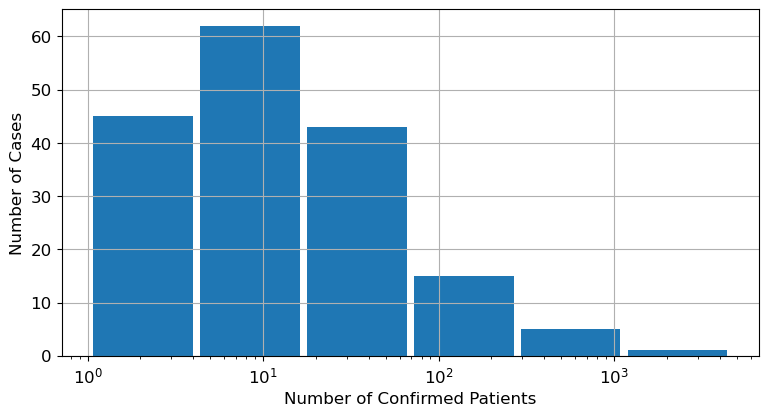

In [30]:
case_bins = create_bins(data['Case'].loc[data['Case']['confirmed']>=1, 'confirmed'], 7, log=True)
fig_case_hist, ax_case_hist = plt.subplots(figsize=(base_fig_wid,base_fig_wid/2))
data['Case'].hist(column='confirmed', bins=case_bins, ax=ax_case_hist,rwidth=0.95)
ax_case_hist.set_xscale('log')
ax_case_hist.set_title(None)
ax_case_hist.set_ylabel('Number of Cases')
ax_case_hist.set_xlabel('Number of Confirmed Patients')

### Case comparison

Classifying infection cases by keywords:

In [31]:
case_filled = data["Case"].copy()
religion_keywords = ["church", "christ", "god", "bibl", "temple", "pastor"]
hospital_keywords = ["hospital", "medic", "patient", "nursing", "shelter"]
education_keywords = [
    "school",
    "day care",
    "institute",
    "kindergarten",
    "academy",
    "class",
]
sports_keywords = ["gym", "sport", "tennis"]
overseas_keywords = ["travel", "overseas"]
community_keywords = ["community", "clubs", "gathering", "family", "celebr", "culture"]
work_keywords = [
    "work",
    "tower",
    "sale",
    "company",
    "manuf",
    "logis",
    "labor",
    "insur",
    "call",
    "ministr",
]

case_filled.loc[
    case_filled["infection_case"].str.contains("|".join(religion_keywords), case=False),
    "type",
] = "Religion"
case_filled.loc[
    case_filled["infection_case"].str.contains("|".join(hospital_keywords), case=False),
    "type",
] = "Medical Facility"
case_filled.loc[
    case_filled["infection_case"].str.contains("|".join(sports_keywords), case=False),
    "type",
] = "Sports"
case_filled.loc[
    case_filled["infection_case"].str.contains(
        "|".join(education_keywords), case=False
    ),
    "type",
] = "Education"
case_filled.loc[
    case_filled["infection_case"].str.contains("|".join(overseas_keywords), case=False),
    "type",
] = "Overseas"
case_filled.loc[
    case_filled["infection_case"].str.contains("|".join(work_keywords), case=False),
    "type",
] = "Workplace"
case_filled.loc[
    case_filled["infection_case"].str.contains(
        "|".join(community_keywords), case=False
    ),
    "type",
] = "Community and Entertainment"
case_filled["type"] = case_filled["type"].fillna("Others")

Case category bar chart:

In [32]:
# | label: fig-case-type
# | fig-cap: Comparison of different case categories. The cases have been categorized based manually selected keywords by location of the case or related institution.
cases_summed_by_type = case_filled.groupby("type")["confirmed"].sum().reset_index()
cases_summed_by_type = cases_summed_by_type.sort_values("confirmed", ascending=False)
fig_case_type = px.bar(
    cases_summed_by_type,
    x="type",
    y="confirmed",
    color='type',
    width=base_fig_wid * dpi,
    height=base_fig_wid / 2 * dpi,
    labels={"confirmed": "Confirmed Cases", "type": "Case Category"},
)
fig_case_type.update_layout(margin=dict(l=10, r=10, t=10, b=10),showlegend=False)
fig_case_type.show()

In [33]:
cases_summed_by_type

,type,confirmed
5,Religion,5514
2,Medical Facility,2265
3,Others,1553
4,Overseas,949
7,Workplace,486
0,Community and Entertainment,383
6,Sports,182
1,Education,63


The majority of the cases, comprising around half of all confirmed patients came from religious institutions. The second most abundant source of infection were medical facilities. Both of these institution are related to a large portion of the elderly population.

Comparing group cases:

In [34]:
case_filled.groupby('group')['confirmed'].sum()

group
False    3544
True     7851
Name: confirmed, dtype: int64

Almost half of all cases are from group infection events. This shows that large gatherings can be a major cause of infection spread.

### Case map

Filling case coordinates that are missing by making geocoding requests and putting the coordinates from the response.

<details>
<summary>Show the code</summary>
case_filled = case_filled.replace('-', np.nan)
bad_case_names=['etc','contact with patient','overseas inflow']
for index, row in case_filled.loc[case_filled['latitude'].isna()].iterrows():
    if isinstance(row['city'],str) and row['city'] != 'from other city':
        if row['infection_case'] in bad_case_names:
            address = row['city']+', '+row['province']+' province, South Korea'
        else:
                address = row['infection_case']+', '+row['city']+', '+row['province']+' province, South Korea'

        url = "https://geocode.maps.co/search?q={address}".format(
        address=address
    )
        response = requests.get(url)
        if response.status_code == 200:
            response_data = response.json()
            try:
                lat = response_data[0]['lat']
                lon = response_data[0]['lon']
                case_filled.loc[index,'latitude']=lat
                case_filled.loc[index,'longitude']=lon
            except:
                address= row['city']+', '+row['province']+' province, South Korea'
                url = "https://geocode.maps.co/search?q={address}".format(
                address=address)
                response = requests.get(url)
                if response.status_code == 200:
                    response_data = response.json()
                    try:
                        lat = response_data[0]['lat']
                        lon = response_data[0]['lon']
                        case_filled.loc[index, 'latitude']=lat
                        case_filled.loc[index, 'longitude']=lon
                    except:
                            print('error with province:'+address)
    else:
        if row['infection_case'] in bad_case_names:
            address = row['province']+' province, South Korea'
        else:
            address = row['infection_case']+', '+row['province']+' province, South Korea'
        url = "https://geocode.maps.co/search?q={address}".format(
        address=address)    
        response = requests.get(url)
        if response.status_code == 200:
            response_data = response.json()
            try:
                lat = response_data[0]['lat']
                lon = response_data[0]['lon']
                case_filled.loc[index,'latitude']=lat
                case_filled.loc[index,'longitude']=lon
            except:
                address=row['province']+' province, South Korea'
                url = "https://geocode.maps.co/search?q={address}".format(
                address=address)
                response = requests.get(url)
                if response.status_code == 200:
                    response_data = response.json()
                    try:
                        lat = response_data[0]['lat']
                        lon = response_data[0]['lon']
                        case_filled.loc[index,'latitude']=lat
                        case_filled.loc[index,'longitude']=lon
                    except:
                            print('error with province:'+address)                
    time.sleep(1.5)

with open('case_filled.pkl', 'wb') as f:
    pickle.dump(case_filled, f)
</details>

In [35]:
with open('case_filled.pkl', 'rb') as f:
    case_filled = pickle.load(f)

<details>
<summary>Show the code</summary>
city_names = data['Case']['city'].unique()[data['Case']['city'].unique()!='from other city']
city_coords={}

for city in city_names:
    address = city+', South Korea'

    url = "https://geocode.maps.co/search?q={address}".format(
        address=address
    )

    response = requests.get(url)

    if response.status_code == 200:
        response_data = response.json()
        try:
            lat = response_data[0]['lat']
            lon = response_data[0]['lon']
            city_coords[city]=[lat,lon]
        except:
            print('error with city:'+address)
    else:
        print(f"Request failed for {address}: {response.status_code}")
    time.sleep(2)

with open('city_coords.pkl', 'wb') as f:
    pickle.dump(city_coords, f)
</details>

Ensuring the coordinates are in a numeric format:

In [36]:
case_filled['latitude']=pd.to_numeric(case_filled['latitude'],errors='coerce')
case_filled['longitude']=pd.to_numeric(case_filled['longitude'],errors='coerce')

Preparing the map:

In [37]:
# | label: fig-case-map
# | fig-cap: Map of South Korea with major covid-19 outbreak cases marked as circles. The circle size represents the magnitude of the outbreak and the colors represent the case category.
fig_case_map = px.choropleth_mapbox(
    mapbox_style="carto-positron",
    center={"lat": 36.5, "lon": 127.7669},
    zoom=5.8,
    height=base_fig_wid * dpi * 0.6,
    width=base_fig_wid * dpi * 0.6,
)
fig_case_map.update_layout(margin=dict(t=20, l=10, b=10, r=10))
case_map_scatter = px.scatter_mapbox(
    case_filled,
    lon="longitude",
    lat="latitude",
    size="confirmed",
    color='type',
    size_max=30,
    hover_data=['confirmed','infection_case','province','city']
)
for trace in case_map_scatter.data:
    fig_case_map.add_trace(trace)
fig_case_map.show()

The map in @fig-case-map shows that the majority of cases come from Daeugu province, most of them is related to a single religious group. The second largest cluster of cases is around the Seoul area and neighboring provinces.

Cleaning the province time data into a dataframe with weekly new case values:

In [38]:
data["TimeProvince"]["date"] = pd.to_datetime(data["TimeProvince"]["date"])
data["TimeProvince"].set_index("date", inplace=True)
weekly_time_province = data["TimeProvince"].groupby('province').resample("W").last()
weekly_time_province["new_cases"] = np.NaN
for province in weekly_time_province["province"]:
    weekly_time_province.loc[
        weekly_time_province["province"] == province, "new_cases"
    ] = weekly_time_province.loc[
        weekly_time_province["province"] == province, "confirmed"
    ] - weekly_time_province.loc[
        weekly_time_province["province"] == province, "confirmed"
    ].shift(
        1
    ).fillna(
        0
    )
weekly_time_province=weekly_time_province.droplevel('province')

In [39]:
fig_province_time = px.line(
    weekly_time_province, y="new_cases",color='province',width=base_fig_wid*dpi
)
fig_province_time.show()

In [40]:
weekly_time_province

,time,province,confirmed,released,deceased,new_cases
date,,,,,,
2020-01-26,16,Busan,0,0,0,0
2020-02-02,16,Busan,0,0,0,0
2020-02-09,16,Busan,0,0,0,0
2020-02-16,16,Busan,0,0,0,0
2020-02-23,16,Busan,19,0,0,19
...,...,...,...,...,...,...
2020-06-07,0,Ulsan,53,46,1,1
2020-06-14,0,Ulsan,53,47,1,0
2020-06-21,0,Ulsan,53,48,1,0


## Patient Data

In [41]:
patients=data['PatientInfo']

### Patient data overview

In [42]:
data['PatientInfo']

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160,7000000015,female,30s,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,25,NaN,2020-05-30,2020-06-13,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


The data comprises of 5165 patients.

Changing date data to datetime

In [43]:
patient_info = data["PatientInfo"].copy()
patient_info["confirmed_date"] = pd.to_datetime(patient_info["confirmed_date"])
patient_info["symptom_onset_date"] = pd.to_datetime(
    patient_info["symptom_onset_date"], errors="coerce"
)
patient_info["released_date"] = pd.to_datetime(
    patient_info["released_date"], errors="coerce"
)
patient_info["deceased_date"] = pd.to_datetime(
    patient_info["deceased_date"], errors="coerce"
)

Average time between symptoms and confirmation:

In [44]:
(patient_info['confirmed_date']-patient_info['symptom_onset_date']).mean().round('D')

Timedelta('5 days 00:00:00')

Average time between confirmation and death:

In [45]:
(patient_info['deceased_date']-patient_info['confirmed_date']).mean().round('D')

Timedelta('11 days 00:00:00')

Age distribution:

In [171]:
# | label: fig-patient-age-hist
# | fig-cap: Histogram of patients by age.
patient_info['age_numeric']=pd.to_numeric(patient_info['age'].str.rstrip('s'))
fig_patient_age_hist=px.histogram(patient_info.sort_values('age_numeric'),x='age',width=base_fig_wid*dpi,height=base_fig_wid/2*dpi,labels={'age':'Age'})
fig_patient_age_hist.update_layout(yaxis_title='Number of Patients')
fig_patient_age_hist.show()

Mortality rate of patients:

In [172]:
round(len(patient_info.loc[patient_info['state']=='deceased'])/len(patient_info)*100,2)

1.51

The patient data shows that covid-19 virus is mostly prevalent in young and middle aged adults, especially those in their 20s. The average time between symptoms and confirmation is 5 days which is in line with literature data for most respiratory infections (@falagas2008). The average time between confirmation and death is 11 days.

### Mortality prediction

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

Data preparation:

In [ ]:
patient_ml_set=patient_info[['age_numeric','sex','province','state']].copy()
patient_ml_set.loc[patient_ml_set['state']!='deceased','state']='alive'
patient_ml_set=patient_ml_set.dropna(how='any')
patient_ml_set=pd.get_dummies(patient_ml_set,columns=['province','sex'])
le=LabelEncoder()
patient_ml_set['state']=le.fit_transform(patient_ml_set['state'])
train_patient, test_patient = train_test_split(
    patient_ml_set,
    test_size=0.3,
    random_state=40,
)

In [83]:
patient_mortality_model=LogisticRegression(solver='lbfgs', max_iter=10000)
patient_mortality_model.fit(train_patient.drop('state',axis=1),train_patient['state'])
patient_prediction=patient_mortality_model.predict(test_patient.drop('state',axis=1))

Correctly predicted positives:

In [84]:
predict_compare=pd.DataFrame({'data':test_patient['state'],'prediction':patient_prediction})
predict_compare.loc[predict_compare["data"] == predict_compare["prediction"]].loc[
    predict_compare.loc[predict_compare["data"] == predict_compare["prediction"]][
        "data"
    ]
    == 1
]

,data,prediction
1518,1,1
1524,1,1


In [101]:
print('Accuracy:')
print(metrics.accuracy_score(predict_compare['data'],predict_compare['prediction']).round(3))
print('Precision Score:')
print(metrics.precision_score(predict_compare['data'],predict_compare['prediction']).round(3))
print('Recall Score:')
print(metrics.recall_score(predict_compare['data'],predict_compare['prediction']).round(3))
print('F1 Score:')
print(metrics.f1_score(predict_compare['data'],predict_compare['prediction']).round(3))

Accuracy:
0.981
Precision Score:
0.667
Recall Score:
0.091
F1 Score:
0.16


In [170]:
patient_mortality_coefficients = pd.DataFrame(
    {
        "Feature": patient_ml_set.drop("state", axis=1).columns,
        "Coefficient": patient_mortality_model.coef_[0],
    }
)
patient_mortality_coefficients = patient_mortality_coefficients.sort_values(
    "Coefficient", ascending=False
).reset_index(drop=True)
non_province_features = ["age_numeric", "sex_male", "sex_female"]
patient_mortality_coefficients.loc[
    patient_mortality_coefficients["Feature"].isin(non_province_features)
].sort_values("Feature")

,Feature,Coefficient
5,age_numeric,0.084
18,sex_female,-0.605
4,sex_male,0.617


In [161]:
patient_mortality_coefficients["Mortality"] = patient_mortality_coefficients[
    "Coefficient"
].apply(lambda x: "Increases" if x > 0 else "Decreases")

non_province_features = ["age_numeric", "sex_male", "sex_female"]

for index, feature_name in enumerate(patient_mortality_coefficients["Feature"]):
    if feature_name[:3] == "pro":
        patient_mortality_coefficients.loc[index, "Feature"] = feature_name.split("_")[
            1
        ]

fig_mortality_coeff = px.bar(
    patient_mortality_coefficients[
        ~patient_mortality_coefficients["Feature"].isin(non_province_features)
    ],
    x="Feature",
    y="Coefficient",
    color='Mortality',
    color_discrete_sequence=["red", "blue"],
    width=base_fig_wid*dpi,
)
fig_mortality_coeff.update_layout(legend=dict(orientation='h',yanchor='top',y=1.1))
fig_mortality_coeff.show()

In [164]:
data['Region'].loc[data['Region']['province'].isin(['Daegu','Gyeonggi-do'])]

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
43,12000,Daegu,Daegu,35.9,129,229,355,11,1.62,15.8,7.5,5083
44,12010,Daegu,Nam-gu,35.8,129,11,15,2,0.85,22.5,10.4,345
45,12020,Daegu,Dalseo-gu,35.8,129,55,78,3,1.72,13.6,6.5,1064
46,12030,Daegu,Dalseong-gun,35.8,128,32,47,1,1.51,12.1,5.4,361
47,12040,Daegu,Dong-gu,35.9,129,32,58,0,1.15,18.8,9,649
48,12050,Daegu,Buk-gu,35.9,129,38,73,4,1.43,13.9,6.3,748
49,12060,Daegu,Seo-gu,35.9,129,17,23,0,0.83,21.3,10.1,374
50,12070,Daegu,Suseong-gu,35.9,129,34,49,1,2.28,15,6.9,948
51,12080,Daegu,Jung-gu,35.9,129,10,12,0,4.03,20.3,9.6,594
82,20000,Gyeonggi-do,Gyeonggi-do,37.3,127,1277,2237,61,1.6,12.6,5.2,20491


## References

::: {#refs}
:::